# The New Heuristic Adviser


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from aegomoku.utils import analyse_board
from aegomoku.policies.heuristic_policy import HeuristicPolicy
from aegomoku.gomoku_board import GomokuBoard
from aegomoku.policies.threat_detector import ThreatDetector
from aegomoku.utils import expand

In [3]:
BOARD_SIZE = 15

In [4]:
stones = "C11F9E9G8F7G7G9H8G6"

## HeuristicPolicy appears to have various biases.
Also, the forward-looking layers, although not so silly, interfere with the MCTS's job.

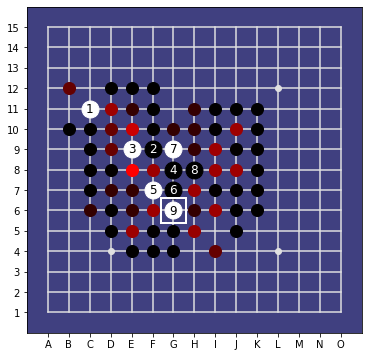

In [5]:
heuristics = HeuristicPolicy(BOARD_SIZE)
analyse_board(BOARD_SIZE, stones, heuristics, disp_width=6)

## Threat Detector Layer
The Threat Detector Layer detects 5 levels of threats/opportunities for both colors -> output: 10 channels

In [6]:
board = GomokuBoard(BOARD_SIZE, stones=stones)
detector = ThreatDetector(BOARD_SIZE)
output = detector(expand(board.math_rep))

#### Some nice visibility tools
The powers of 2 in the probe layer allow the transparent identification of all detected threat levels

In [7]:
probe = tf.keras.layers.Conv2D(
    name='project',
    filters=1, kernel_size=(1, 1),
    trainable=False,
    kernel_initializer=tf.constant_initializer([512, 256, 128, 64, 32, 16, 8, 4, 2, 1]))

peel = tf.keras.layers.Conv2D(
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([
        [[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]
    ]),
    bias_initializer=tf.constant_initializer(0.),
    trainable=False)

sum_channels = tf.keras.layers.Conv2D(
    name='heuristic_priority',
    filters=1, kernel_size=(1, 1),
    trainable=False,
    kernel_initializer=tf.constant_initializer([1.] * 10))

def print_channel(data, channel=None):
    """
    :param data: policy output, either one or six channels
    :param channel: if data is 6-channel, number of channel from 1: strongest offensive opportunity to 6 weakest defensive
    :return:
    """
    if np.shape(data)[-1] == 10:
        if channel is not None:
            channel -= 1
            data = np.expand_dims(data[:,:,:,channel], -1)
        else:
            data = probe(data)
    data = peel(data)
    print((data.numpy().reshape([15, 15]) ).astype(np.uint))

In [8]:
print_channel(probe(output))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  9  1  2  1  2  1  0  0  0  0  0  0]
 [ 0  1  1  4  9  3  3  3  2  8  0  0  0  0  0]
 [ 1  0  1  6  0  0  0  3  9  0  0  0  0  0  0]
 [ 0  0  0  1 15 11  0  0  9  8  0  0  0  0  0]
 [ 0  0  1  3  3  0  0 11  3  0  0  0  0  0  0]
 [ 0  0  0  0  3  9  0  3  9  2  0  0  0  0  0]
 [ 0  0  0  1  8  1  1  4  2  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


## The new Heuristic Adviser

### Step 1: Detect the threat patterns

In [9]:
board = GomokuBoard(BOARD_SIZE, stones=stones)
detector = ThreatDetector(BOARD_SIZE)
output = detector(expand(board.math_rep))
output.shape

TensorShape([1, 17, 17, 10])

### Step 2: Assign criticality values to the detector channels

In [10]:
kernel = np.diag([999, 333, 99, 33, 2, 2, 2, 2, 1, 1])
criticality = tf.keras.layers.Conv2D(
    name='weights',
    filters=10, kernel_size=(1, 1),
    trainable=False,
    kernel_initializer=tf.constant_initializer(kernel))

In [11]:
crit0 = criticality(output)
print_channel(sum_channels(crit0))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 3 1 1 1 1 1 0 0 0 0 0 0]
 [0 1 1 2 3 2 2 2 1 2 0 0 0 0 0]
 [1 0 1 3 0 0 0 2 3 0 0 0 0 0 0]
 [0 0 0 1 6 4 0 0 3 2 0 0 0 0 0]
 [0 0 1 2 2 0 0 4 2 0 0 0 0 0 0]
 [0 0 0 0 2 3 0 2 3 1 0 0 0 0 0]
 [0 0 0 1 2 1 1 2 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Criticalities don't actually sum up regularly

We use a trick: add n-th powers under the n-th root

$$
p_{total} = \sqrt[n]{\sum(p_i)^n}
$$

This way, the *sum* of any set of numbers is bigger, yet always close to the largest number. Anything added to *critical* is still somewhat *critical*, although - maybe - somewhat more.

In [12]:
crit1 = tf.pow(crit0, 4)
crit1 = sum_channels(crit1)
crit1 = tf.pow(crit1, .25)
print_channel(crit1)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 2 1 1 1 1 1 0 0 0 0 0 0]
 [0 1 1 2 2 1 1 1 1 2 0 0 0 0 0]
 [1 0 1 2 0 0 0 1 2 0 0 0 0 0 0]
 [0 0 0 1 2 2 0 0 2 2 0 0 0 0 0]
 [0 0 1 1 1 0 0 2 1 0 0 0 0 0 0]
 [0 0 0 0 1 2 0 1 2 1 0 0 0 0 0]
 [0 0 0 1 2 1 1 2 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## The full advice will apply softmax and thresholds

In [13]:
flatten = tf.keras.layers.Flatten()
crit = tf.squeeze(flatten(crit1))

threshold = 0.004
softmax = tf.keras.layers.Softmax()(crit)
softmax = tf.keras.activations.relu(softmax - threshold)

softmax = tf.reshape(softmax, [1, 17, 17, 1])
sup = np.max(softmax, axis=None)
threshold = sup * .01
softmax = tf.nn.relu(softmax - threshold)
softmax = softmax / np.sum(softmax)

print_channel(softmax*100)
print(np.sum(tf.sign(softmax)))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 4 1 1 1 0 4 0 0 0 0 0]
 [0 0 0 4 0 0 0 1 4 0 0 0 0 0 0]
 [0 0 0 0 7 4 0 0 4 4 0 0 0 0 0]
 [0 0 0 1 1 0 0 4 1 0 0 0 0 0 0]
 [0 0 0 0 1 4 0 1 4 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
52.0


#### All of that now ready to use in `HeuristicAdviser`

In [14]:
from aegomoku.policies.heuristic_value_model import HeuristicValueModel
from aegomoku.policies.heuristic_advice import HeuristicPolicyParams, HeuristicAdviser, HeuristicValueParams

value_params = HeuristicValueParams(board_size=BOARD_SIZE)
value_model = HeuristicValueModel(value_params)
adviser = HeuristicAdviser(HeuristicPolicyParams(board_size=BOARD_SIZE), value_model)
p, v = adviser.call(expand(board.math_rep))
print((p.numpy().reshape([BOARD_SIZE, BOARD_SIZE])*100).astype(np.uint))
v

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 2 1 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


<tf.Tensor: shape=(), dtype=float32, numpy=0.279746>

[B12, D11, D10, E10, J10, D9, I9, E8, F8, I8, J8, H7, F6, I6, E5, H5, I4]


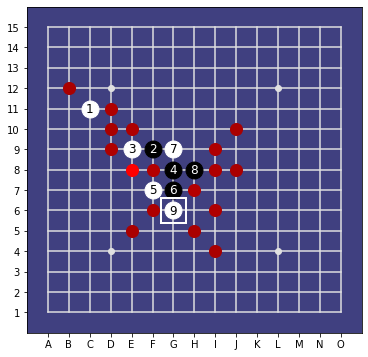

In [15]:
advisable = adviser.get_advisable_actions(board.math_rep)
print([board.Stone(i) for i in advisable])
analyse_board(BOARD_SIZE, stones, adviser, disp_width=6, policy_cutoff=0.001)